# AcousticBrainz Genre Task 2017: Content-based music genre recognition from multiple sources

In [1]:
# Nice graphs for high dpi screens
%config InlineBackend.figure_format = 'retina'

## Install and import packages

In [2]:
!pip install -U scikit-learn[alldeps]
!pip install -U python-dotenv
!pip install -U pandas


Requirement already up-to-date: scikit-learn[alldeps] in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages
Requirement already up-to-date: numpy>=1.6.1; extra == "alldeps" in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages (from scikit-learn[alldeps])
Requirement already up-to-date: scipy>=0.9; extra == "alldeps" in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages (from scikit-learn[alldeps])
Requirement already up-to-date: python-dotenv in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages
Requirement already up-to-date: click>=5.0 in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages (from python-dotenv)
Requirement already up-to-date: pandas in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages
Requirement already up-to-date: numpy>=1.7.0 in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages

In [3]:
from os import environ
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

settings = {
    "path": environ.get("PATH_TO_DATASET"),
    "loaded_data": environ.get('LOADED_TRAINING_DATA'),
    
    "very_few": environ.get('VERY_FEW_RECORDS', False),  # Limit the dataset to very few records, useful during development
}

You **must** restart the kernel after first instaling or updating packages!

In [17]:
from sklearn import svm
import pandas as pd
import json


In [5]:
# Read tsv file into groundtruth and extract only id and main genre from it
groundtruth_raw = pd.read_table(settings['path'] + 'groundtruth/acousticbrainz-mediaeval2017-tagtraum-train.tsv')
groundtruth_raw = groundtruth_raw[['recordingmbid', 'genre1']]

def isInLoadedDataset(id):
    return id[0] in settings['loaded_data']
    
groundtruth_available = groundtruth_raw.apply(lambda x: isInLoadedDataset(x['recordingmbid']), axis=1)
groundtruth = groundtruth_raw[groundtruth_available]
print 'Groundtruth raw: %d' % len(groundtruth_raw)
print 'Groundtruth only available: %d' % len(groundtruth)


print 'Found {} unique genres.'.format(len(groundtruth['genre1'].unique()))


Groundtruth raw: 486740
Groundtruth only available: 30599
Found 31 unique genres.


In [6]:

if settings['very_few']:
    groundtruth = groundtruth.head(10000)


## Data Understanding

In [31]:
from collections import Counter
genre = Counter(groundtruth.genre1).keys() # equals to list(set(words))
counter = Counter(groundtruth.genre1).values() # counts the elements' frequency

# genre_list = []
# for i in genre:
#     genre_list[i] = [genre[i], counter[i]]
df = pd.DataFrame(genre)
df_2 = pd.DataFrame(counter)
df_new = pd.concat([df, df_2], axis=1)
df_new

,0,0
0,industrial,256
1,childrens,41
2,classical,516
3,dance,1520
4,reggaeton,1
5,dubstep,128
6,blues,777
7,electronic,2106
8,folk,739
9,trance,137


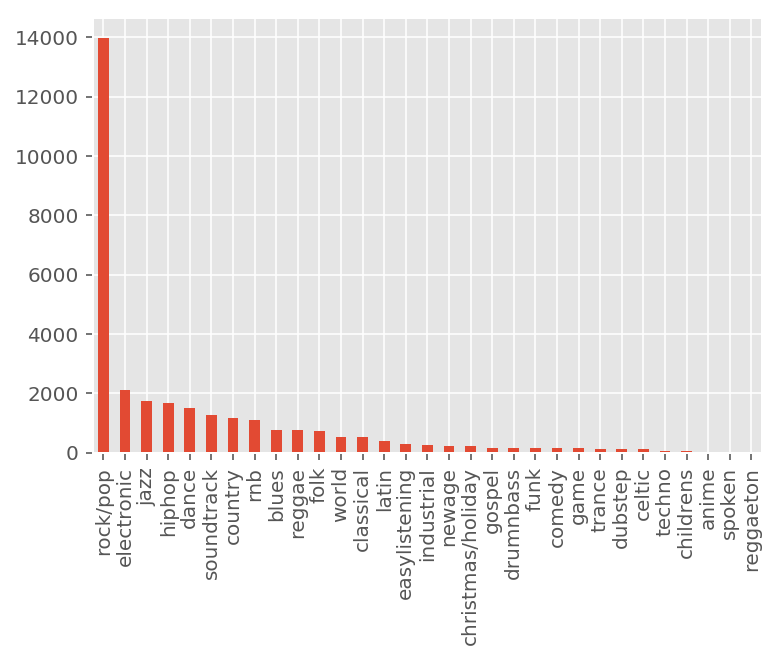

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

groundtruth.genre1.value_counts().plot(kind='bar')
plt.show()
 #show power distribution

## Utility functions

In [131]:
def loadFeatures(recordingmbid):
    feature_file_path = '{basepath}acousticbrainz-mediaeval-train/{id_prefix}/{id}.json'.format(
        basepath = settings['path'], id_prefix=recordingmbid[0:2], id = recordingmbid);
    
    with open(feature_file_path) as feature_file:    
        data = json.load(feature_file)
    
    return data

def pettyPrintJSON(object_to_print):
    print(json.dumps(object_to_print, sort_keys=True, indent=4))
    

def getOnlyUsedFeatures(recordingmbid):
    
    all_features = loadFeatures(recordingmbid)
    
    used_features = [
        'lowlevel.mfcc.mean',
        'lowlevel.average_loudness']
        #'lowlevel.spectral_energy.mean']
    
    result_features = []
    
    for feature_name in used_features:
        reduced_features = all_features

        for k in feature_name.split('.'):
            reduced_features = reduced_features[k]
            
        reduced_features = [reduced_features]
        result_features.extend(reduced_features)
        
    return pd.Series(result_features)
    

training_data = groundtruth['recordingmbid'].apply(getOnlyUsedFeatures)

print training_data.head()

                                                     0         1
53   [-657.453918457, 131.168411255, -21.3965606689...  0.855276
75   [-655.049865723, 114.80153656, 8.42422485352, ...  0.865318
76   [-636.922363281, 87.851020813, -3.9413626194, ...  0.904938
79   [-668.672058105, 112.563072205, -10.8580093384...  0.877631
101  [-766.844360352, 163.622360229, 32.5675163269,...  0.432806


### See distribution of average loudness of rock/pop music

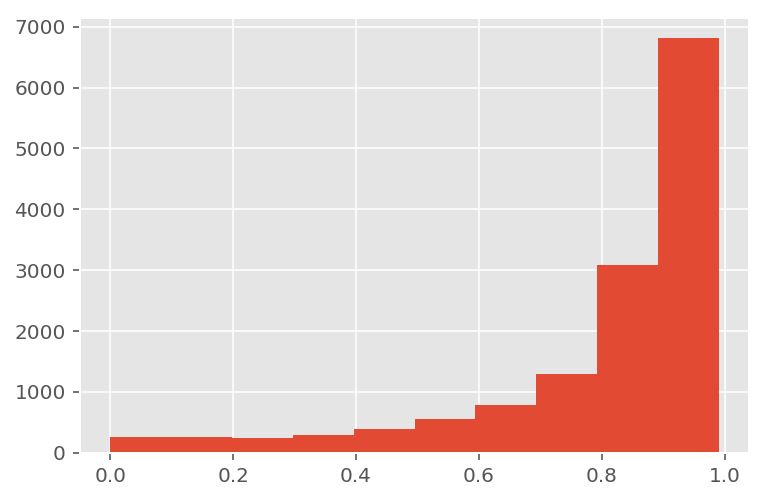

In [125]:
groundtruth_rock = groundtruth[groundtruth['genre1'] == "rock/pop"]
training_data_rock = groundtruth_rock['recordingmbid'].apply(getOnlyUsedFeatures)
plt.hist(training_data_rock)
plt.show()

In [132]:
training_data[0:-2]

,0,1
53,"[-657.453918457, 131.168411255, -21.3965606689...",0.855276
75,"[-655.049865723, 114.80153656, 8.42422485352, ...",0.865318
76,"[-636.922363281, 87.851020813, -3.9413626194, ...",0.904938
79,"[-668.672058105, 112.563072205, -10.8580093384...",0.877631
101,"[-766.844360352, 163.622360229, 32.5675163269,...",0.432806
107,"[-670.917785645, 94.5471115112, -9.60056400299...",0.601012
125,"[-772.901855469, 103.339653015, 16.6911659241,...",0.087278
142,"[-686.494812012, 111.846061707, 10.0638360977,...",0.669827
181,"[-789.287353516, 156.830245972, -6.36619758606...",0.023583
182,"[-627.244445801, 111.023803711, -1.02745771408...",0.928549


## Train SVM

In [129]:


clf = svm.SVC()
clf.fit(training_data[0:-2], groundtruth['genre1'][0:-2])  

ValueError: setting an array element with a sequence.

In [ ]:

test_features = training_data[-1:]
test_label = groundtruth['genre1'][-1:]
print test_label
print clf.predict(test_features)

In [ ]:
 pettyPrintJSON(loadFeatures('1a00a335-fead-46ec-8d4f-06e8341291ea'))